# Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики RMSE на тестовой выборке должно быть не больше 48.

**Инструкция по выполнению проекта**

- Загрузите данные и выполните их ресемплирование по одному часу.
- Проанализируйте данные.
- Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
- Проверьте данные на тестовой выборке и сделайте выводы.

**Описание данных**

Данные лежат в файле taxi.csv. Количество заказов находится в столбце 'num_orders' (от англ. number of orders, «число заказов»).

**План выполнения проектной работы**

- Подготовка 
- Анализ 
- Обучение 
- Тестирование 

In [1]:
import pandas as pd
import numpy as np
from numpy.random import RandomState

from matplotlib import pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

STATE = 12345
import warnings
warnings.filterwarnings('ignore')

## Подготовка данных

Загрузим данные и изучим сведения о них:

In [2]:
data = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])


In [3]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [6]:
data.shape

(26496, 1)

In [7]:
print(data.index.is_monotonic)
print(data.index.is_unique)
print(data.isna().sum())

True
True
num_orders    0
dtype: int64


Произведем ресемплирование данных по одному часу:

In [8]:
df_resampled = data.resample('1H').sum()

In [9]:
df_resampled

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


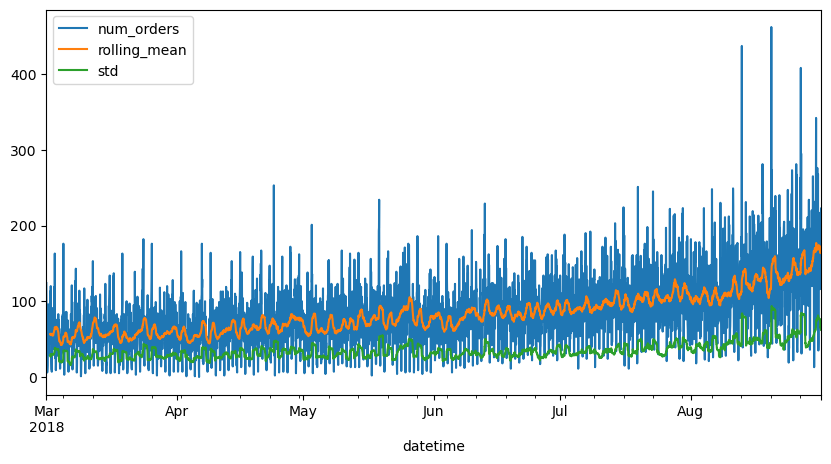

In [10]:
df_resampled['rolling_mean'] = df_resampled['num_orders'].rolling(24).mean()
df_resampled['std'] = df_resampled['num_orders'].rolling(24).std()
df_resampled.plot(figsize=(10,5))
plt.show()

По графику временного ряда можно отметить, что есть небольшой восходящий тренд, а стандартное отклонение практически не меняется

## Анализ данных

Проведем декомпозицию данных, визуализируем полученные результаты с помощью графиков.

Рассмотрим данные за все время

In [11]:
df_resampled = data.resample('1H').sum()

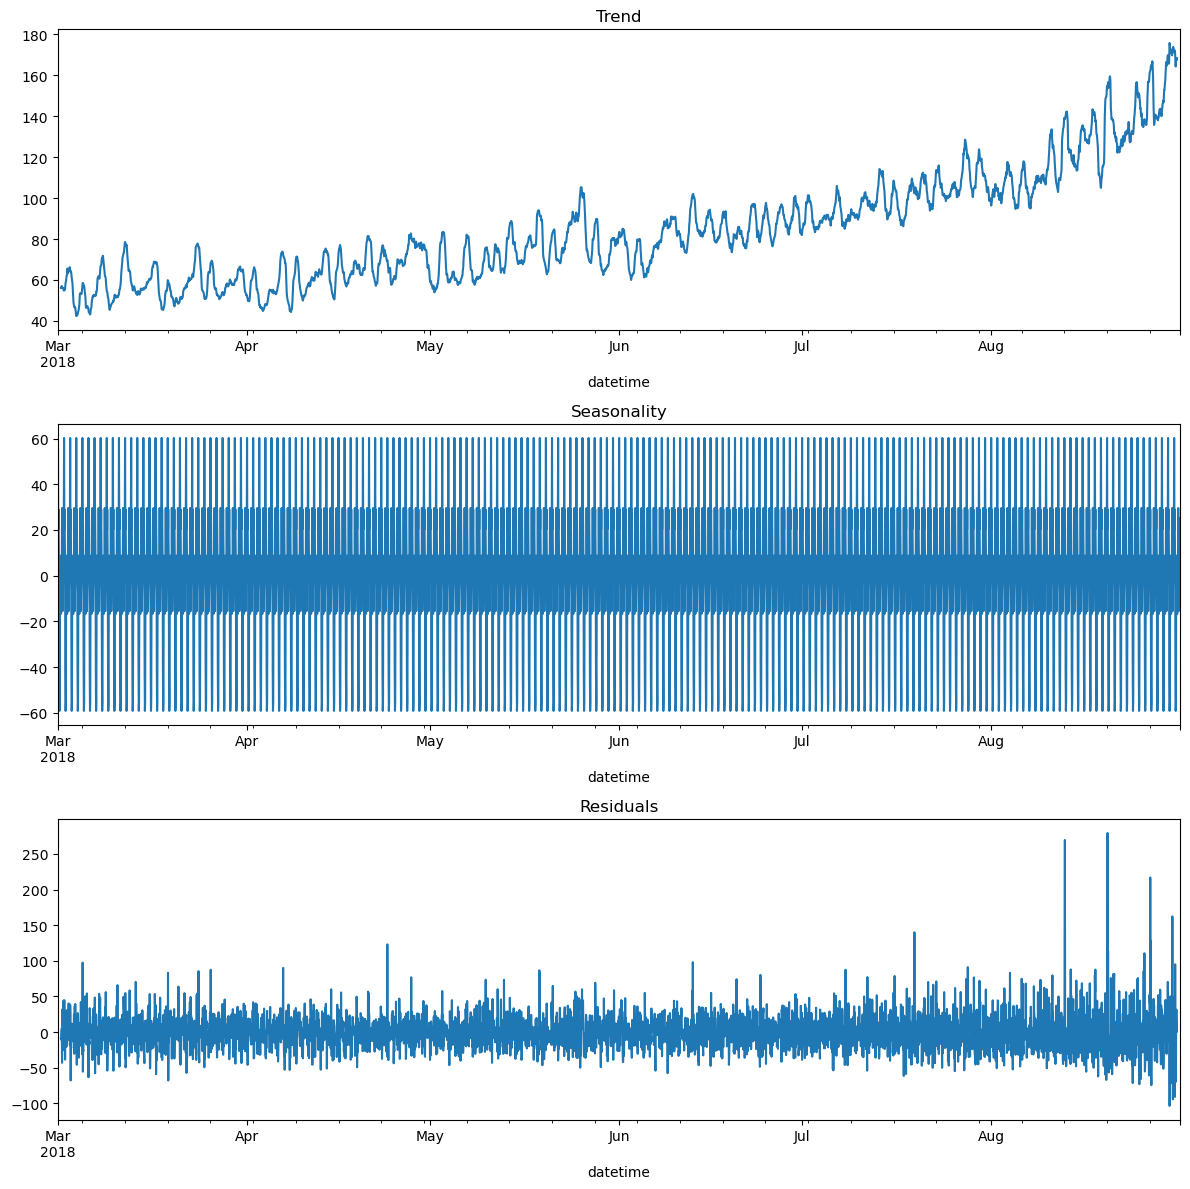

In [12]:
decomposed = seasonal_decompose(df_resampled)
plt.figure(figsize=(12, 12))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())

plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())

plt.title('Residuals')
plt.tight_layout()

Тренд имеет зависимость от времени. Поскольку предсказания нам нужны на час вперед, будем читать, что тренд линеен.

Далее изучим сезонность, тренд и остатки для одного месяца

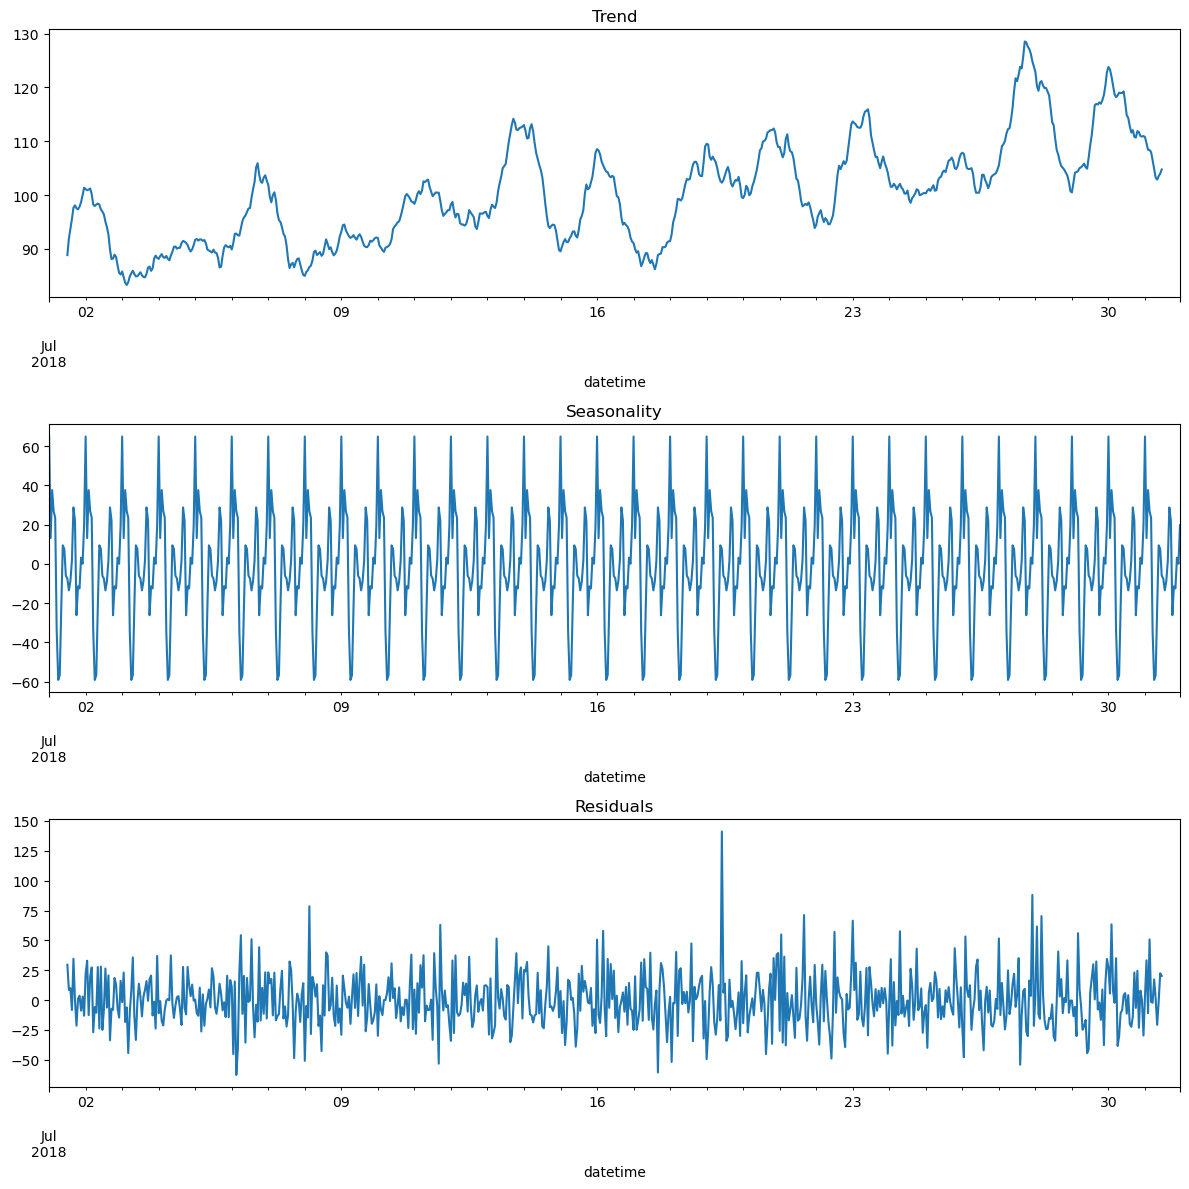

In [13]:
decomposed = seasonal_decompose(df_resampled['2018-07':'2018-07'])
plt.figure(figsize=(12, 12))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())

plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())

plt.title('Residuals')
plt.tight_layout()

Распределение сезонности в течение суток статистическое, с пиками в вечернее время.
Случайная часть имеет постоянное среднее значение, но встречаются всплески, которые можно соотнести с повышенным спросом.
Тренд показывает линейный рост количества заказов.

Рассмотрим, так же, скользящее среднее с окном в двадцать часов в течение месяца.

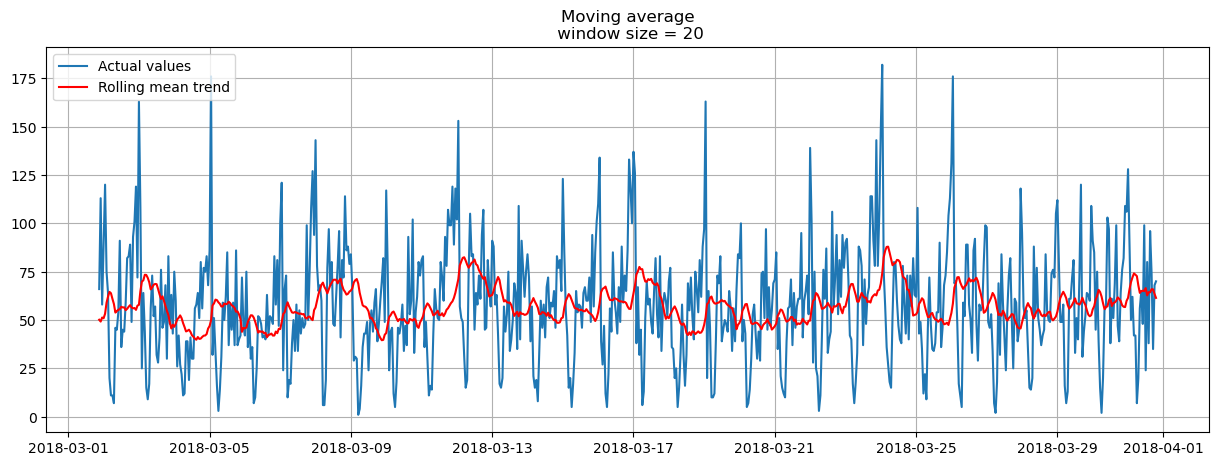

In [14]:
dt = 24*30
n = 20

series=df_resampled.num_orders

rolling_mean = series.rolling(window=n).mean().shift(1)

plt.figure(figsize=(15,5))
plt.title("Moving average\n window size = {}".format(n))
plt.plot(series[n+1:n+dt], label="Actual values")
plt.plot(rolling_mean[n+1:n+dt], "r", label="Rolling mean trend")

plt.legend(loc="upper left")
plt.grid(True)

## Обучение

Разобьем данные на тренировочную и тестовую выборки, с размером тестовой выборки равным 10% от датасета.

In [15]:
train, test = train_test_split(df_resampled, shuffle=False, test_size=0.1)
train = train.dropna()

В качестве baseline предскажем новые значения предыдущими.

In [16]:
pred_previous = test.shift()
pred_previous.iloc[0] = train.iloc[-1]
rmse_base =  mean_squared_error(test['num_orders'], pred_previous, squared=False)
print("RMSE baseline модели:", round(rmse_base, 3))

RMSE baseline модели: 58.856


Сравним с предсказаниями по среднему:

In [17]:
pred_mean = np.ones(test.shape) * train['num_orders'].mean()
print("RMSE baseline модели:", mean_squared_error(test['num_orders'], pred_mean, squared=False))

RMSE baseline модели: 84.74414402014742


Предсказания предущим значением показывают лучшее значение метрики rmse и будут в дальнейшем использованы в качестве baseline

Напишем функцию для создания обучающих признаков. Создадим признак dayofweek, а так же скользящего среднего rolling_mean (с размером окна rolling_mean_size), и lag_i для признаков отстающего значения.

In [18]:
def make_features(data, max_lag, rolling_mean_size):
    df = data.copy()
    df['dayofweek'] = df.index.dayofweek
    df['day'] = df.index.day
    df['hour'] = df.index.hour
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return df

In [19]:
df = make_features(df_resampled, 30, 50)

In [20]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

display(train.head())

,num_orders,dayofweek,day,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-03 02:00:00,25,5,3,2,108.0,163.0,72.0,119.0,101.0,93.0,...,20.0,64.0,75.0,120.0,90.0,58.0,113.0,66.0,61.0,62.82
2018-03-03 03:00:00,64,5,3,3,25.0,108.0,163.0,72.0,119.0,101.0,...,11.0,20.0,64.0,75.0,120.0,90.0,58.0,113.0,66.0,60.84
2018-03-03 04:00:00,44,5,3,4,64.0,25.0,108.0,163.0,72.0,119.0,...,11.0,11.0,20.0,64.0,75.0,120.0,90.0,58.0,113.0,60.42
2018-03-03 05:00:00,15,5,3,5,44.0,64.0,25.0,108.0,163.0,72.0,...,7.0,11.0,11.0,20.0,64.0,75.0,120.0,90.0,58.0,59.88
2018-03-03 06:00:00,9,5,3,6,15.0,44.0,64.0,25.0,108.0,163.0,...,46.0,7.0,11.0,11.0,20.0,64.0,75.0,120.0,90.0,58.86


Создадим функцию для расчета метрики rmse

In [21]:
def rmse(actual, pred):
    actual, pred = np.array(actual), np.array(pred)
    return np.sqrt(np.square(np.subtract(actual,pred)).mean())

In [22]:
rmse_score = make_scorer(rmse, greater_is_better=False)

**Линейная регрессия**

Проведем кросс-валидацию для оценки линейной регрессии на тренировочной выборке.

In [23]:
cv = TimeSeriesSplit(n_splits=5)

In [24]:
X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']
X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

lm = LinearRegression()

print(cross_val_score(lm, X_train, y_train, scoring=rmse_score))

[-20.92967903 -22.85459658 -24.74270013 -25.74319477 -32.82750301]


In [25]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(n_estimators=150, random_state=STATE))
])

params = [
    {
        'model': [RandomForestRegressor(n_estimators=100, random_state=STATE)],
        'model__max_features': np.linspace(0.1, 1, 5)
    },
     { 
         'model': [LinearRegression()]
    }, {
        'model': [Lasso(random_state=STATE)],
        'model__alpha': np.logspace(-3, 1, 10)
    }, {
        'model': [Ridge(random_state=STATE)],
        'model__alpha': np.logspace(-3, 1, 5)
    }
]


In [26]:
cv = TimeSeriesSplit(n_splits=10)
grid = GridSearchCV(pipe, param_grid=params, cv=cv, n_jobs=-1, scoring=rmse_score)

In [27]:
%%time
grid.fit(X_train, y_train)

Wall time: 20.8 s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model',
                                        RandomForestRegressor(n_estimators=150,
                                                              random_state=RandomState(MT19937) at 0x1D218252640))]),
             n_jobs=-1,
             param_grid=[{'model': [RandomForestRegressor(max_features=0.55,
                                                          random_state=RandomState(MT19937) at 0x...
                          'model__alpha': array([1.00000000e-03, 2.78255940e-03, 7.74263683e-03, 2.15443469e-02,
       5.99484250e-02, 1.66810054e-01, 4.64158883e-01, 1.29154967e+00,
       3.59381366e+00, 1.00000000e+01])},
                         {'model': [Ridge(random_state=RandomState(MT19937) at 0x1D218252640)],
                          'model__alpha': array([1.e-03, 1.e-02, 1.e-0

In [28]:
print('Лучшие параметры:', grid.best_params_)
print('Лучшая оценка rmse:', grid.best_score_)

Лучшие параметры: {'model': RandomForestRegressor(max_features=0.55,
                      random_state=RandomState(MT19937) at 0x1D218252640), 'model__max_features': 0.55}
Лучшая оценка rmse: -23.998301295386966


## Тестирование

In [29]:
pipe = grid.best_estimator_

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

rmse_test = rmse(y_test, y_pred)

In [30]:
print(rmse_test)

42.475349468173164


Модель случайного леса показывает удовлетворительный результат (размер метрики, в соответствии с требованиями, меньше 48). 

Для лучшей модели построим график зависимости таргета и предсказаний от времени.

In [37]:
df = make_features(df_resampled, 96, 41)
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()
X_train = train.drop('num_orders', axis=1)
y_train = train['num_orders']
X_test = test.drop('num_orders', axis=1)
y_test = test['num_orders']

rf = RandomForestRegressor(n_estimators=100, random_state=STATE)
rf.fit(X_train, y_train)
pred_test = pd.Series(rf.predict(X_test), index = y_test.index, name='preds')

In [38]:
df_pred = pd.concat([y_test, pred_test], axis=1)
df_pred.head(10)

,num_orders,preds
datetime,,
2018-08-13 14:00:00,102,96.19
2018-08-13 15:00:00,175,122.47
2018-08-13 16:00:00,144,157.98
2018-08-13 17:00:00,152,141.29
2018-08-13 18:00:00,104,103.41
2018-08-13 19:00:00,91,101.25
2018-08-13 20:00:00,82,98.48
2018-08-13 21:00:00,160,113.16
2018-08-13 22:00:00,104,121.26


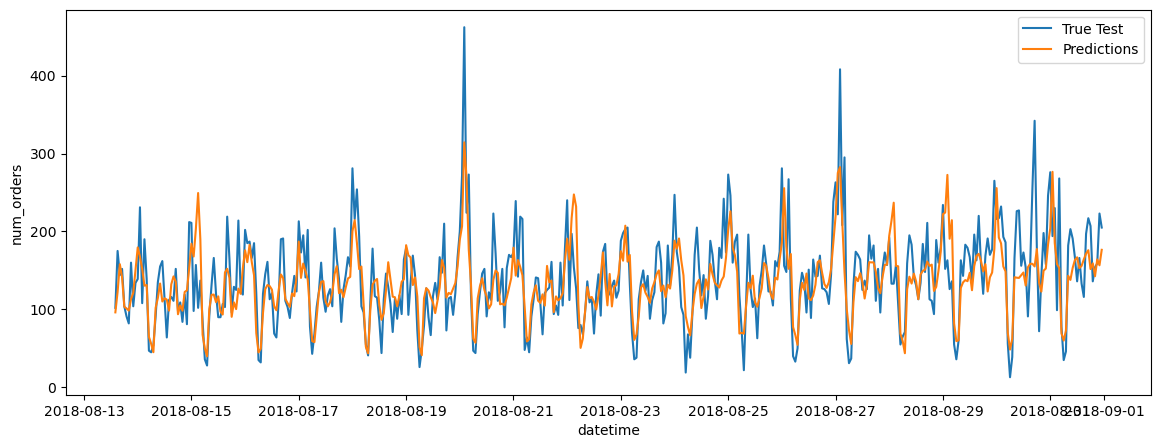

In [39]:
plt.figure(figsize=(14, 5))
data = df_pred['2018-07-01':]
sns.lineplot(x=data.index, y=data['num_orders'], label='True Test')
sns.lineplot(x=data.index, y=data['preds'], label='Predictions')
plt.show()

На представленной визуализации можно обратить внимание, что модель довольно успешно предсказывает целевые признаки, однако не справляется с выбросами. Стоит рассмотреть возможность внесения дополнительных признаков для обучения.

## Вывод

В ходе выполнения проектной работы было проведено изучение и анализ данных, ресемплирование данных по одному часу.

Была проведена декомпозиция временных рядов, сравнение показателей за весь период собранный в датасете и за один месяц.

Мы провели обучение и тестирование линейных моделей.

Лучший результат на тестовой выборке показала модель RandomForestRegressor.

Метрика составила 42.475, что ниже 48. Цель исследования достигнута.